# Model with 4 labels, using pre-trained model Resnet50

In [1]:
import os
import random
import tensorflow as tf
import pandas as pd
import numpy as np
import shutil
import seaborn
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, LearningRateScheduler, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
%load_ext tensorboard
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report

In [2]:
# src_path: input the path of the folder, where the whole data is stored
# label_path: dataframe which includes label data

src_path="C:/MA_Yijie_Ma/0_Datensatz/0_Training_Datensatz/1_40_Spulen/TrainingsDatensatz"
label_path = os.path.join(src_path, "40_Spulen_MultiLabel_v1.csv")
saveModel_path = "D:/MA_Yijie_Ma/0_Datensatz/0_Training_Datensatz/1_40_Spulen/Modelle/Resnet50_MultiOuput_v1.h5"
#save_logs_path = "D:/MA_Yijie_Ma/0_Datensatz/0_Training_Datensatz/1_40_Spulen/Logs/MultiOuput_Resnet50_4Outputs_v1_logs"

In [3]:
# Using pretrained ResNet50 in the head of the Networks
pre_trained_model = ResNet50(input_shape=(224,224,3),
                                include_top=False,
                                weights="imagenet")

for layer in pre_trained_model.layers:
    layer.trainable=False

last_layer = pre_trained_model.get_layer("conv5_block3_out")
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024,activation="relu")(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add 4 final sigmoid layer for classification

inOrdnung = layers.Dense(1, activation = 'sigmoid', name="0_inOrdnung")(x)
Doppelwindung = layers.Dense(1, activation = 'sigmoid', name = "1_Doppelwindung")(x)
Luecke = layers.Dense(1, activation = 'sigmoid', name = "2_Luecke")(x)
Kreuzung = layers.Dense(1, activation = 'sigmoid', name = "3_Kreuzung")(x)
    

model = Model(pre_trained_model.input, [inOrdnung, Doppelwindung, Luecke, Kreuzung])
model.compile(optimizer=RMSprop(lr = 0.001, decay = 1e-6),
              loss = ["binary_crossentropy","binary_crossentropy","binary_crossentropy","binary_crossentropy"],
              metrics = ["accuracy"])


model.summary()

last layer output shape:  (None, 7, 7, 2048)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________________________

conv4_block4_3_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block4_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block4_add (Add)          (None, 14, 14, 1024) 0           conv4_block3_out[0][0]           
                                                                 conv4_block4_3_bn[0][0]          
__________________________________________________________________________________________________
conv4_block4_out (Activation)   (None, 14, 14, 1024) 0           conv4_block4_add[0][0]           
__________________________________________________________________________________________________
conv4_block5_1_conv (Conv2D)    (None, 14, 14, 256)  262400      conv4_block4_out[0][0]           
__________________________________________________________________________________________________
conv4_block5_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block5_1_conv[0][0]        
__________

# here below we shuffle the dataframe after reading it

In [4]:
def generator_wrapper(generator):
    for batch_x,batch_y in generator:
        yield batch_x, [np.array(batch_y[:,i]) for i in range(4)]


df=pd.read_csv(label_path)

###.....................................................

df = df.sample(frac=1,random_state=1234513).reset_index(drop=True)

###.....................................................

columns=["0_inOrdnung", "1_Doppelwindung", "2_Luecke","3_Kreuzung"]

datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.15)
#train_datagen=ImageDataGenerator(rescale=1./255.)
#valid_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(
dataframe=df,
directory=src_path,
x_col="Image",
y_col=columns,
subset="training",
batch_size=64,
shuffle=True,
class_mode="raw",
target_size=(224,224))

valid_generator=datagen.flow_from_dataframe(
dataframe=df,
directory=src_path,
x_col="Image",
y_col=columns,
subset="validation",
batch_size=64,
shuffle=True,
class_mode="raw",
target_size=(224,224))

Found 32336 validated image filenames.
Found 5706 validated image filenames.


In [ ]:
# Using EarlyStopping Callbacks 
earlystopping = EarlyStopping(
                patience=5,
                min_delta=0,
                mode='min',
                monitor='val_loss',
                restore_best_weights=True,
                verbose=1)

# Using Tesorboard Callbacks
#tensorboard_callback = TensorBoard(log_dir=save_logs_path)

# Using ReduceLROnPlateau Callbacks
reduce_lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.2,
                             patience = 3, min_lr=0.0001)

# Using Checkpoint Callbacks
checkpoint_filepath = saveModel_path
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    verbose = 0,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_freq='epoch')

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size


history = model.fit(train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              epochs=2000,
                              verbose=1,
                              callbacks=[earlystopping, reduce_lr, checkpoint],
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              use_multiprocessing=False,
                              workers=6)




Epoch 1/2000
505/505 [==============================] - ETA: 0s - loss: 3.7506 - 0_inOrdnung_loss: 1.0069 - 1_Doppelwindung_loss: 0.8479 - 2_Luecke_loss: 0.8568 - 3_Kreuzung_loss: 1.0390 - 0_inOrdnung_accuracy: 0.6164 - 1_Doppelwindung_accuracy: 0.6198 - 2_Luecke_accuracy: 0.6218 - 3_Kreuzung_accuracy: 0.6201WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000195EBE603A8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silenc

# Evaluate and Plot

In [6]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l],  label= str(l) + '(' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l],  label= str(l) + '(' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.legend(bbox_to_anchor=(1.,.5),loc = "center left")
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
   
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l],  label= str(l) + '(' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l],  label= str(l) + '(' + str(format(history.history[l][-1],'.5f'))+')')

    plt.legend(bbox_to_anchor=(1.,.5),loc = "center left") 
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    plt.show()

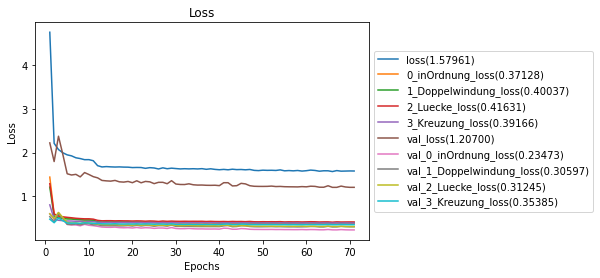

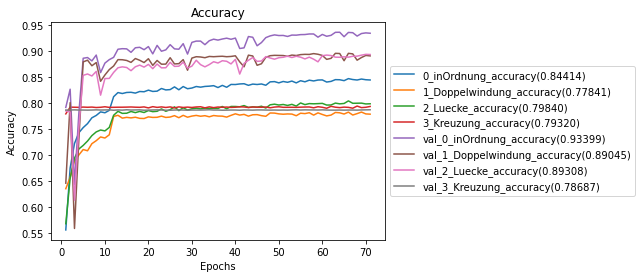

In [7]:
plot_history(history)

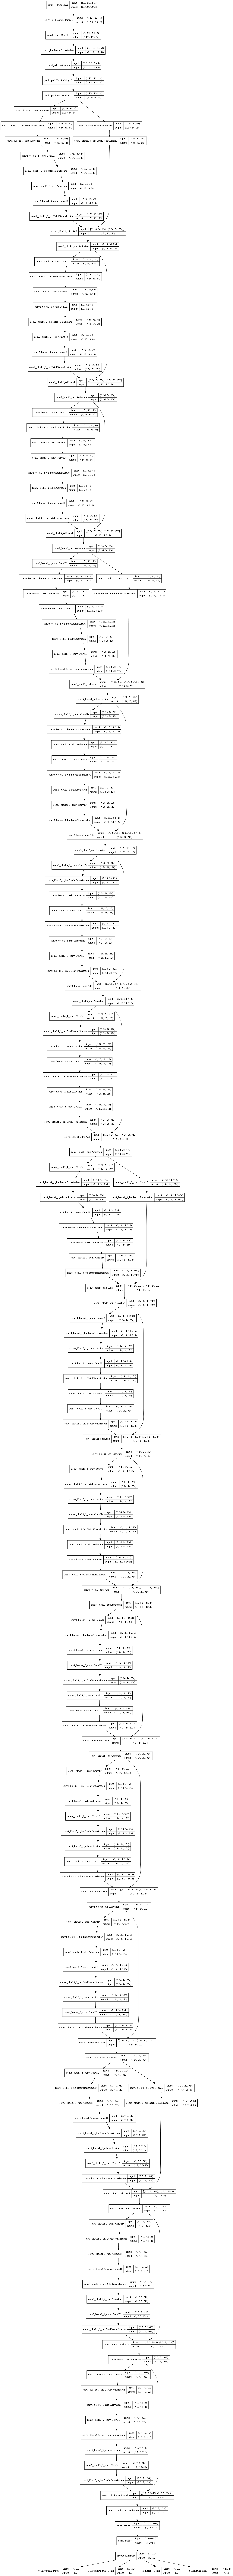

In [11]:
from tensorflow.python.keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

In [19]:
model.save(saveModel_path)

In [20]:
valid_generator_cm=datagen.flow_from_dataframe(
dataframe=df,
directory=src_path,
x_col="Image",
y_col=columns,
subset="validation",
batch_size=1,
shuffle=False,
class_mode="raw",
target_size=(224,224))

Y_pred = model.predict_generator(generator_wrapper(valid_generator_cm),steps=valid_generator_cm.n, verbose = 1)
Y_pred = np.squeeze(Y_pred, axis = 2)
Y_pred = (Y_pred> 0.5).astype(int).astype(float)
Y_pred = Y_pred.T

Y_true = valid_generator_cm.labels


print("the shape of Y_true is: ", Y_true.shape)
print("Y_true is: ", Y_true)
print("the shape of Y_pred is: ", Y_pred.shape)
print("Y_pred is: ", Y_pred)

Found 5706 validated image filenames.
Instructions for updating:
Please use Model.predict, which supports generators.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
5706/5706 [==============================] - 90s 16ms/step
the shape of Y_true is:  (5706, 4)
Y_true is:  [[0 0 0 0]
 [1 1 0 1]
 [1 1 1 1]
 ...
 [0 0 0 0]
 [1 1 1 1]
 [0 0 0 0]]
the shape of Y_pred is:  (5706, 4)
Y_pred is:  [[0. 0. 0. 0.]
 [1. 1. 0. 1.]
 [1. 

In [21]:
#draw the classification report and confusion matrix

mlcm = multilabel_confusion_matrix(Y_true, Y_pred)

print("the confusion matrix is:\n",mlcm)
print("the shape of the confusion matrix is:\n",mlcm.shape)

print("Classification Report:\n")

print(classification_report(Y_true, Y_pred))


the confusion matrix is:
 [[[2940   51]
  [  35 2680]]

 [[3719   62]
  [  56 1869]]

 [[3176  115]
  [  51 2364]]

 [[4551   33]
  [ 175  947]]]
the shape of the confusion matrix is:
 (4, 2, 2)
Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2715
           1       0.97      0.97      0.97      1925
           2       0.95      0.98      0.97      2415
           3       0.97      0.84      0.90      1122

   micro avg       0.97      0.96      0.96      8177
   macro avg       0.97      0.95      0.96      8177
weighted avg       0.97      0.96      0.96      8177
 samples avg       0.46      0.46      0.46      8177



C:\ProgramData\Anaconda3\envs\MA_Yijie_Ma_v1\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\MA_Yijie_Ma_v1\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


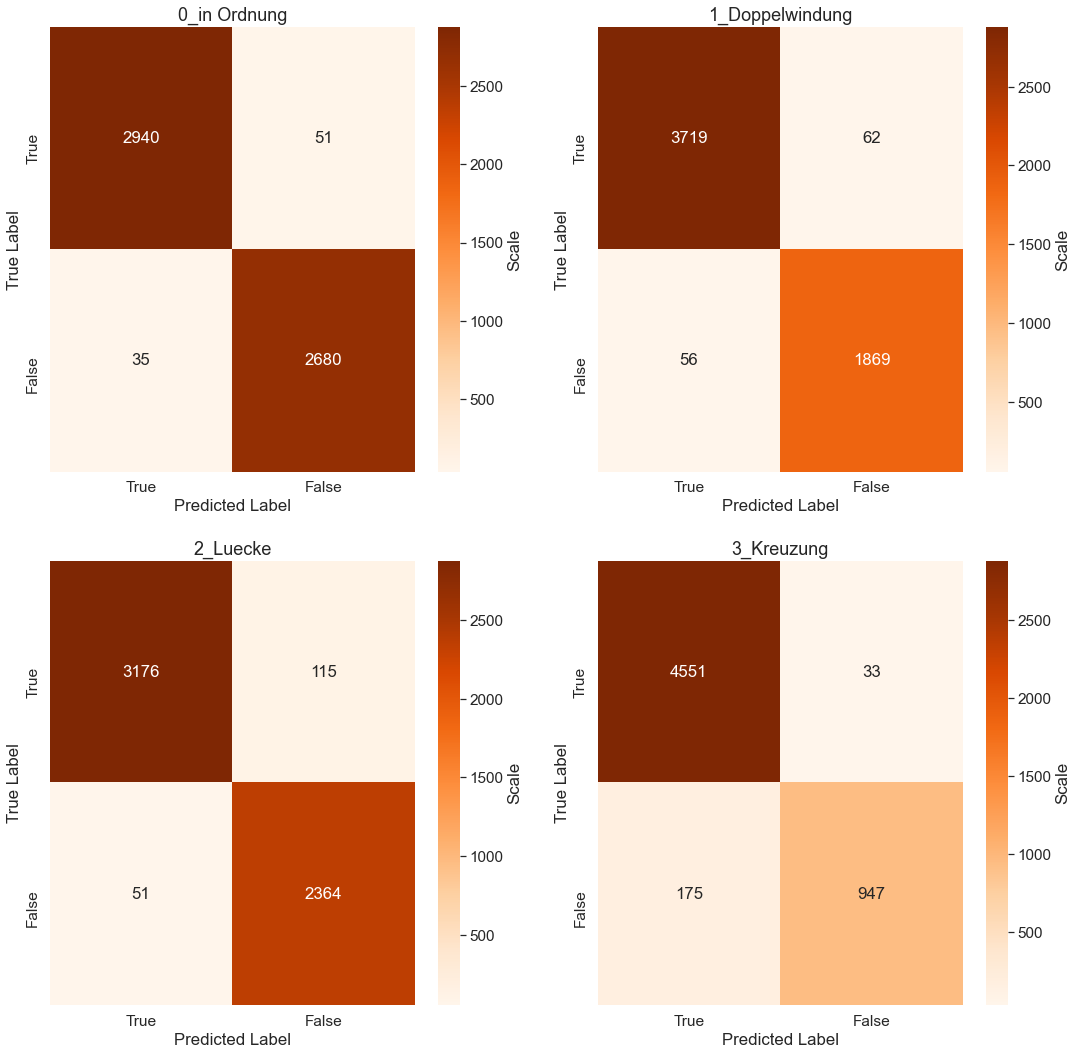

In [27]:
def plot_confusion_matrix(data, labels, title):
    """Plot confusion matrix using heatmap.
 
    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.
 
    """
    seaborn.set(color_codes=True)
    #plt.figure()
 
    plt.title(title,fontsize = 18)
 
    seaborn.set(font_scale=1.4)
    ax = seaborn.heatmap(data, annot=True, cmap='Oranges', vmax=2880, fmt =".0f", cbar_kws={'label': 'Scale'})
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")
 
    #plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    #plt.close()
    #plt.imshow()
    
 
# define data
plt.figure(figsize=(18,18))
titles=["0_in Ordnung", "1_Doppelwindung", "2_Luecke", "3_Kreuzung"]

for i in range(4):
    plt.subplot(2,2,i+1)
    data = mlcm[i,:,:] 
    title = titles[i]
    # define labels
    labels = ["True", "False"]

    # create confusion matrix
    plot_confusion_matrix(data, labels, title)


plt.imshow
plt.savefig("ConfusionMmatrix_MultiOutput_Resnet50_4outputs_v1.png", bbox_inches='tight', dpi=300)

In [28]:
test_df = pd.read_csv("D:/MA_Yijie_Ma/0_Datensatz/1_Test_Datensatz/testdf.csv", header=0)
test_path = "D:/MA_Yijie_Ma/0_Datensatz/1_Test_Datensatz/Linearwickel_700_Spulen"

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
dataframe=test_df,
directory=test_path,
x_col="Image",
batch_size=1,
shuffle=False,
class_mode=None,
target_size=(224,224))

#STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

test_generator.reset()

pred = model.predict_generator(test_generator,
    verbose=1)

Found 662399 validated image filenames.
662399/662399 [==============================] - 13789s 21ms/step


In [29]:
pred_squeeze = np.squeeze(pred, axis=2)
predictions = (pred_squeeze> 0.5).T.astype(int)
print(predictions)

columns=["0_in Ordnung", "1_Doppelwindung", "2_Luecke", "3_Kreuzung"]

#columns should be the same order of y_col
results=pd.DataFrame(predictions, columns=columns)
results["Image"]=test_df.Image
ordered_cols=["Image"]+columns
results=results[ordered_cols]#To get the same column order
results.to_csv("Lineawickel_700_Spulen.csv",index=False)

[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 ...
 [1 0 1 0]
 [1 0 1 0]
 [0 0 0 0]]


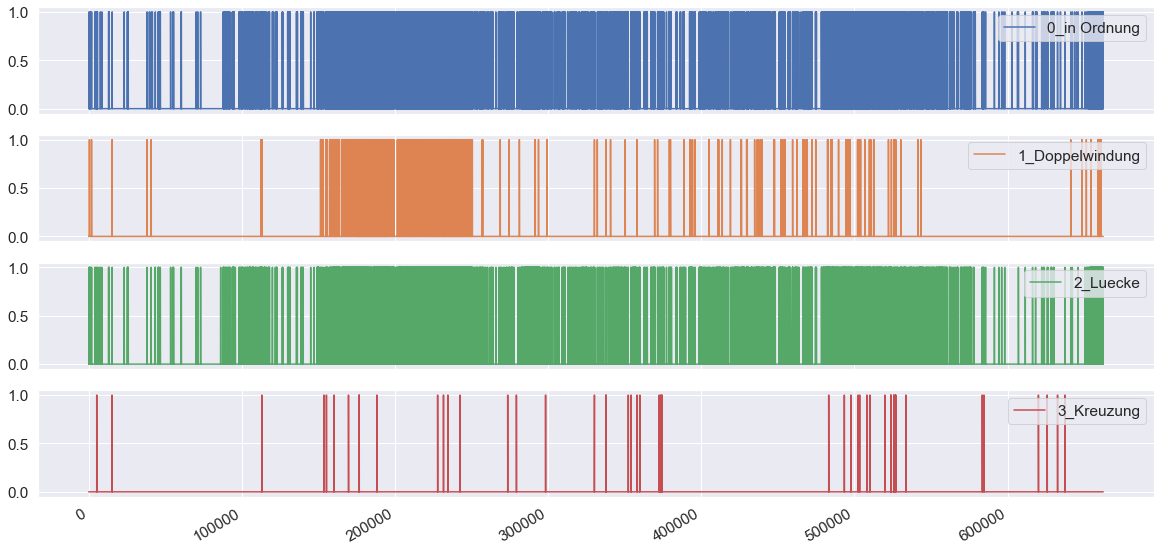

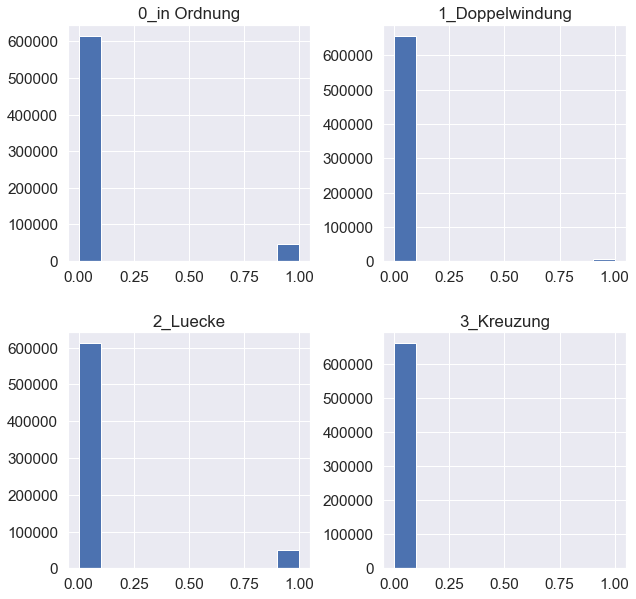

In [41]:
final = pd.read_csv("Lineawickel_700_Spulen.csv")
final
final.plot(subplots = True, figsize = (20,10))
final.hist(figsize = (10,10))


plt.savefig('Analysis_Prediction.ipynbMultiOuput_Resnet50_4Outputs_v1.jpg')
plt.show()